# HECRASController Profiles

In [ ]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

import sys
from pathlib import Path

if USE_LOCAL_SOURCE:
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import RasCmdr, RasControl, RasExamples, RasPlan, init_ras_project, ras

# Additional imports for this notebook
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from IPython import display

# Verify which version loaded
import ras_commander
print(f"Loaded: {ras_commander.__file__}")

## Prerequisites

Before running this notebook, ensure you have:

1. **ras-commander installed**: `pip install ras-commander`
2. **Python 3.10+**: Check with `python --version`
3. **HEC-RAS 5.x or earlier**: COM interface requires legacy versions
4. **pywin32**: `pip install pywin32`

### What You'll Learn

This notebook demonstrates **legacy COM-based automation** using `RasControl`:

- **HECRASController**: COM interface for HEC-RAS 3.x-5.x
- **Steady Flow Results**: Extract profiles from steady flow runs
- **Unsteady Flow Results**: Time series data from unsteady runs
- **Comparison Across Versions**: Run same project in multiple HEC-RAS versions

### Related Notebooks

- **110_single_plan_execution.ipynb** - Modern API-based execution (HEC-RAS 6.x+)
- **120_automating_ras_with_win32com.ipynb** - GUI automation

### Critical Information: HEC-RAS Version Compatibility

**RasControl (COM interface)**:
- **Supported**: HEC-RAS 3.x, 4.x, 5.x
- **NOT Supported**: HEC-RAS 6.x+ (no COM interface)

**Modern API** (RasCmdr, HdfResultsPlan):
- **Supported**: HEC-RAS 6.x+
- **Limited**: HEC-RAS 5.x (some features)
- **NOT Supported**: HEC-RAS 3.x-4.x (use RasControl)

### When to Use RasControl

**Use RasControl when**:
1. Working with HEC-RAS 5.x projects
2. Need to compare results across HEC-RAS versions
3. Legacy systems require COM interface
4. Accessing features not yet in modern API

**Use modern API when**:
1. HEC-RAS 6.x or later
2. New projects (start with latest HEC-RAS)
3. Production workflows (faster, more reliable)
4. HDF-based results preferred

### Migration Path: Legacy → Modern

**Step 1**: Upgrade project to HEC-RAS 6.x
```python
# Open in HEC-RAS 6.x GUI
# File → Save As (converts to 6.x format)
```

**Step 2**: Replace RasControl with RasCmdr
```python
# ❌ Legacy (RasControl - HEC-RAS 5.x)
RasControl.compute_plan("01")
df = RasControl.get_steady_results("01")

# ✅ Modern (RasCmdr - HEC-RAS 6.x)
RasCmdr.compute_plan("01")
hdf = HdfResultsPlan(ras.plan_df.loc[0, 'hdf_path'])
df = hdf.get_wse_dataframe()
```

### Verification: COM-Based Execution

**Success Criteria**:
- HEC-RAS opens automatically (COM instantiation)
- Project loads in HEC-RAS window
- Plan computes without errors
- Results extracted to DataFrame

**Visual Inspection**:
1. HEC-RAS GUI window should appear
2. Project name visible in title bar
3. Computation messages shown in HEC-RAS window
4. Results available in HEC-RAS viewer

**Troubleshooting COM Errors**:

**Error 1: "COM object not found"**
```python
# Verify HEC-RAS is registered
import win32com.client

try:
    ras_ctrl = win32com.client.Dispatch("RAS66.HECRASController")
    print("[OK] HEC-RAS COM registered")
except Exception as e:
    print(f"[ERROR] COM registration issue: {e}")
    print("Solution: Reinstall HEC-RAS or run as Administrator")
```

**Error 2: "Project won't open"**
```python
# Check project file path
from pathlib import Path

prj_file = Path(project_folder) / "project.prj"
assert prj_file.exists(), f"Project file not found: {prj_file}"
print(f"[OK] Project file exists: {prj_file}")
```

**Error 3: "Results not extracting"**
```python
# Verify plan computed successfully
# Check HEC-RAS GUI for computation messages
# Look for "Run completed successfully"
```

### Understanding COM Output Structure

RasControl returns results in **different formats** than modern API:

**Steady Flow** (RasControl.get_steady_results):
```python
# Returns DataFrame with columns:
# - river_id
# - reach_id
# - node_id
# - profile (profile number/name)
# - wse (water surface elevation)
# - velocity
# - etc.
```

**Unsteady Flow** (RasControl.get_unsteady_results):
```python
# Returns DataFrame with columns:
# - river_id
# - reach_id
# - node_id
# - datetime (parsed from computation)
# - wse
# - velocity
# - etc.
```

## Parameters

Configure these values to customize the notebook for your project.

In [ ]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

print(f"Project: {PROJECT_NAME}")
print(f"HEC-RAS Version: {RAS_VERSION}")


# Working with Legacy HEC-RAS Using RasControl

This notebook demonstrates **RasControl**, which provides a ras-commander style API for legacy HEC-RAS versions (3.x-4.x) using the HECRASController COM interface.

## What is RasControl?

**RasControl** wraps the HECRASController COM API with ras-commander conventions:

- ✅ **Use plan numbers** - `RasControl.run_plan("02")` not file paths
- ✅ **Integrated with ras object** - Works with `init_ras_project()`
- ✅ **Steady AND unsteady** - Extract profiles and time series
- ✅ **Auto-sets current plan** - Just pass the plan number!
- ✅ **No COM complexity** - Clean public API

## When to Use RasControl

| Use RasControl | Use HDF Methods |
|----------------|----------------|
| HEC-RAS 3.1, 4.1 | HEC-RAS 6.0+ |
| No HDF support | Modern versions |
| Legacy models | 2D mesh data |
| Version migration | Better performance |

## Supported Versions

3.0, 3.1, 4.0, 4.1, 5.0-5.0.7, 6.0-6.7 Beta

Accepts: `"4.1"`, `"41"`, `"5.0.6"`, `"506"`, `"6.6"`, `"66"`, etc.

## Setup

In [4]:
# ============================================================================
# PLOTTING CONFIGURATION
# ============================================================================

# Set better default plotting parameters
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

import numpy as np  # Add if not already imported

print("✓ Plotting configuration loaded")


✓ Plotting configuration loaded


## Extract and Initialize Project

In [ ]:
# Extract example project
project_path = RasExamples.extract_project("Balde Eagle Creek", suffix="17")

# Initialize project with HEC-RAS 6.6
init_ras_project(project_path, RAS_VERSION)

print(f"✓ Project initialized: {project_path}")

In [10]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,10MIN,1,...,None,dss,2,None,01,C:\GH\ras-commander\examples\example_projects\...,02,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,...,None,dss,1,None,01,C:\GH\ras-commander\examples\example_projects\...,02,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Steady


# Part 1: Steady State (Plan 02)

Extract steady profiles. **Note:** `run_plan()` automatically sets Plan 02 as current!

In [ ]:
# =============================================================================
# Run Plan 02 (Steady Flow)
# =============================================================================
# Must run the plan before extracting results
print("Running Plan 02 (Steady Flow)...")
RasCmdr.compute_plan("02", num_cores=2)
print("✓ Plan 02 completed")

### Extracting Computation Messages (Steady Flow)

After running the plan, we can extract detailed computation messages using `RasControl.get_comp_msgs()`. This method:
- Reads from `.comp_msgs.txt` or `.computeMsgs.txt` files (version-dependent)
- Falls back to HDF extraction if .txt files not available
- Returns detailed information about the computation process

In [12]:
# Extract computation messages for steady flow Plan 02
print("="*80)
print("COMPUTATION MESSAGES - Plan 02 (Steady Flow)")
print("="*80)

msgs_steady = RasControl.get_comp_msgs("02")

if msgs_steady:
    print(f"\nExtracted {len(msgs_steady)} characters of computation messages\n")
    
    # Display first 800 characters
    print("Computation messages (first 800 characters):")
    print("-" * 80)
    print(msgs_steady[:800])
    
    if len(msgs_steady) > 800:
        print("\n... (truncated) ...")
else:
    print("No computation messages available for Plan 02")

print("\n" + "="*80)

2025-11-17 14:05:51 - ras_commander.RasControl - WARNING - Computation messages .txt file not found (tried .comp_msgs.txt and .computeMsgs.txt), falling back to HDF extraction


2025-11-17 14:05:51 - ras_commander.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02.hdf


2025-11-17 14:05:51 - ras_commander.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p02.hdf


2025-11-17 14:05:51 - ras_commander.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagle.p02.hdf


2025-11-17 14:05:51 - ras_commander.HdfResultsPlan - INFO - Successfully extracted 718 characters from HDF


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Successfully retrieved 718 characters from HDF


COMPUTATION MESSAGES - Plan 02 (Steady Flow)

Extracted 718 characters of computation messages

Computation messages (first 800 characters):
--------------------------------------------------------------------------------
Plan: 'Steady Flow Run' (BaldEagle.p02)
Simulation started at: 17Nov2025 02:05:47 PM

Writing Plan GIS Data...
Completed Writing Plan GIS Data
Writing Geometry...
Computing Bank Lines
Bank lines generated in 113 ms
Computing Edge Lines
Edge Lines generated in 57 ms
Computing XS Interpolation Surface
XS Interpolation Surface generated in 122 ms
Completed Writing Geometry
Writing Event Conditions ...
Completed Writing Event Condition Data

	
Steady Flow Simulation HEC-RAS 6.6 September 2024
 

Finished Steady Flow Simulation


Computations Summary

Computation Task	Time(hh:mm:ss)
Completing Geometry, Flow and Plan	       1
Steady Flow Computations	       1
Complete Process	       3




In [13]:
# Extract steady results (auto-sets Plan 02 as current)
df_steady = RasControl.get_steady_results("02")

print(f"Rows: {len(df_steady)}")
print(f"Profiles: {df_steady['profile'].nunique()}")
print(f"XS: {df_steady['node_id'].nunique()}")
df_steady.head(10)

2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


2025-11-17 14:05:51 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Detected ras.exe PID 385752 (confidence: 100/100)


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Setting current plan to: Steady Flow Run


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Found 8 profiles


2025-11-17 14:05:52 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - Extracted 1424 result rows


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:05:54 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 385752


Rows: 1424
Profiles: 8
XS: 178


,river,reach,node_id,profile,wsel,min_ch_el,velocity,flow,froude,energy,max_depth
0,Bald Eagle,Loc Hav,138154.4,.5 year,660.588928,656.299988,3.657029,1.177402,0.363896,660.775635,4.288940
1,Bald Eagle,Loc Hav,138154.4,1 year,661.432068,656.299988,3.888445,1.654405,0.358103,661.629578,5.132080
2,Bald Eagle,Loc Hav,138154.4,2 year,662.602600,656.299988,4.519829,2.233629,0.365692,662.858398,6.302612
3,Bald Eagle,Loc Hav,138154.4,5 year,664.673218,656.299988,5.791487,3.227041,0.396946,665.082153,8.373230
4,Bald Eagle,Loc Hav,138154.4,10 year,666.190918,656.299988,6.828511,3.987156,0.426974,666.755981,9.890930
5,Bald Eagle,Loc Hav,138154.4,25 year,667.459351,656.299988,7.730279,4.592227,0.449943,668.181274,11.159363
6,Bald Eagle,Loc Hav,138154.4,50 year,668.543640,656.299988,8.564765,5.127679,0.471433,669.427612,12.243652
7,Bald Eagle,Loc Hav,138154.4,100 year,669.521484,656.299988,9.320695,5.608300,0.490210,670.566101,13.221497
8,Bald Eagle,Loc Hav,137690.8,.5 year,659.914612,653.729980,3.339625,0.703524,0.282183,660.072205,6.184631
9,Bald Eagle,Loc Hav,137690.8,1 year,660.849548,653.729980,3.501968,1.028502,0.274149,661.000366,7.119568


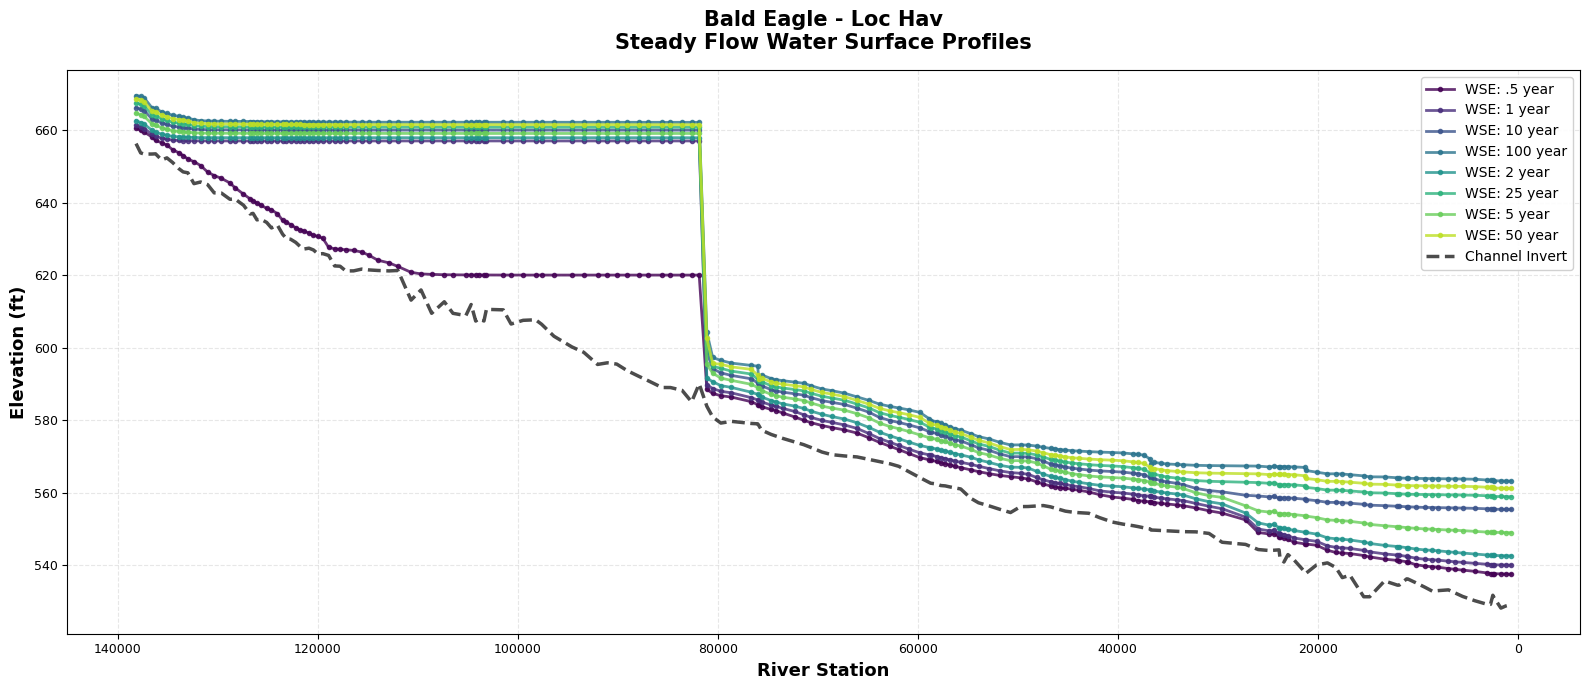

✓ Plotted 8 profiles for Bald Eagle - Loc Hav
  Station range: 659.9 to 138154.4



In [14]:
# ============================================================================
# STEADY FLOW: Longitudinal Profiles by River/Reach
# ============================================================================

# Convert node_id to float for proper sorting
df_steady['node_id'] = df_steady['node_id'].astype(float)

# Group by River/Reach and create separate plots
for (river, reach), group_df in df_steady.groupby(['river', 'reach']):
    
    # Sort by station (descending - upstream to downstream per HEC-RAS convention)
    group_df_sorted = group_df.sort_values('node_id', ascending=False)
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # Get unique profiles and plot each one
    profiles = sorted(group_df['profile'].unique())
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(profiles)))
    
    for idx, profile in enumerate(profiles):
        prof_data = group_df_sorted[group_df_sorted['profile'] == profile]
        ax.plot(prof_data['node_id'], prof_data['wsel'], 
                marker='o', markersize=3, linewidth=2, 
                color=colors[idx], label=f'WSE: {profile}', alpha=0.8)
    
    # Add channel invert (plot once, not for each profile)
    invert = group_df_sorted.drop_duplicates('node_id')[['node_id', 'min_ch_el']].sort_values('node_id', ascending=False)
    ax.plot(invert['node_id'], invert['min_ch_el'], 
            'k--', linewidth=2.5, alpha=0.7, label='Channel Invert')
    
    # Formatting
    ax.set_xlabel('River Station', fontsize=13, fontweight='bold')
    ax.set_ylabel('Elevation (ft)', fontsize=13, fontweight='bold')
    ax.set_title(f'{river} - {reach}\nSteady Flow Water Surface Profiles', 
                 fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.invert_xaxis()  # Upstream (larger stations) on left
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Plotted {len(profiles)} profiles for {river} - {reach}")
    print(f"  Station range: {group_df['node_id'].min():.1f} to {group_df['node_id'].max():.1f}\n")

In [15]:
# Export
Path("working").mkdir(exist_ok=True)
df_steady.to_csv("working/steady_plan02.csv", index=False)
print(f"Exported {len(df_steady)} rows to working/steady_plan02.csv")

Exported 1424 rows to working/steady_plan02.csv


# Part 2: Unsteady Time Series (Plan 01)

Extract unsteady results. **Note:** Methods automatically set Plan 01 as current!

In [ ]:
# Run Plan 01 (auto-sets as current, waits for completion)
# This may take 5-10 minutes!
print("Running Plan 01 (Unsteady)...")
# NOTE: Using RasCmdr.compute_plan() instead of RasControl.run_plan() 
# because RasControl.run_plan() always sets cores to max
RasCmdr.compute_plan("01", clear_geompre=True, num_cores=2)
print("✓ Plan 01 completed")

In [17]:
# Get output times (auto-sets Plan 01 as current)
times = RasControl.get_output_times("01")
print(f"Found {len(times)} timesteps")
print(f"First: {times[0]}")
print(f"Last: {times[-1]}")

2025-11-17 14:07:31 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Detected ras.exe PID 385348 (confidence: 100/100)


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady with Bridges and Dam


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Found 76 output times


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 385348


Found 76 timesteps
First: Max WS
Last: 24FEB1999 0400


### Extracting Computation Messages (Unsteady Flow)

Similarly, we can extract computation messages for the unsteady flow plan to review:
- Simulation timing and performance
- Convergence information
- Any warnings or errors encountered during computation

In [18]:
# Extract computation messages for unsteady flow Plan 01
print("="*80)
print("COMPUTATION MESSAGES - Plan 01 (Unsteady Flow)")
print("="*80)

msgs_unsteady = RasControl.get_comp_msgs("01")

if msgs_unsteady:
    print(f"\nExtracted {len(msgs_unsteady)} characters of computation messages\n")
    
    # Display first 800 characters
    print("Computation messages (first 800 characters):")
    print("-" * 80)
    print(msgs_unsteady[:800])
    
    if len(msgs_unsteady) > 800:
        print("\n... (truncated) ...")
    
    # Check for errors/warnings
    print("\n" + "="*80)
    print("Checking for warnings/errors...")
    print("="*80)
    
    lines = msgs_unsteady.split('\n')
    issues = [l for l in lines if 'error' in l.lower() or 'warning' in l.lower()]
    
    if issues:
        print(f"Found {len(issues)} warning/error lines:")
        for issue in issues[:5]:  # Show first 5
            print(f"  - {issue.strip()}")
    else:
        print("✓ No warnings or errors found")
else:
    print("No computation messages available for Plan 01")

print("\n" + "="*80)

2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Reading computation messages from: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.comp_msgs.txt


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Read 1175 characters from comp_msgs file


COMPUTATION MESSAGES - Plan 01 (Unsteady Flow)

Extracted 1175 characters of computation messages

Computation messages (first 800 characters):
--------------------------------------------------------------------------------
User selected to use previously computed internal boundary data 
but the geometry preprocessor file was for the previous version.
All internal boundary data will be recomputed.

Simulation started at: 14Nov2012 01:29 PM

Writing geometry to output file
Completed writing geometry to output file


Writing plan information to output file
Completed writing plan information to output file


Geometric Preprocessor Version 4.2.0 Jan 2010 XXX XXXX

Finished Processing Geometry
GeomPreprocessor complete - Accepting the preprocessor files.

Performing Unsteady Flow Simulation  Version 4.2.0 Jan 2010 XXX XXXX

Maximum iterations of 20 at: 		RS	WSEL	ERROR
20FEB1999 12:44:00  Bald Eagle      	Loc Hav         	75917.82	  592.36	   0.012


Finished Unsteady Flow Simulation

Writi

In [19]:
# Extract unsteady (limit to 10 timesteps for demo)
df_unsteady = RasControl.get_unsteady_results("01")

print(f"Rows: {len(df_unsteady)}")
print(f"Timesteps: {df_unsteady['time_index'].nunique()}")
print(f"XS: {df_unsteady['node_id'].nunique()}")
df_unsteady.head(10)

2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Opening HEC-RAS: RAS66.HECRASController (version: 6.6)


2025-11-17 14:07:32 - ras_commander.RasControl - INFO - Opening project: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.prj


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Detected ras.exe PID 384072 (confidence: 100/100)


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Executing operation...


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Setting current plan to: Unsteady with Bridges and Dam


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Extracting 76 time steps


2025-11-17 14:07:33 - ras_commander.RasControl - INFO - Found 1 rivers


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - Extracted 13528 result rows


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - Operation completed successfully


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - Closing HEC-RAS...


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - HEC-RAS closed via QuitRas()


2025-11-17 14:08:04 - ras_commander.RasControl - INFO - Terminating tracked ras.exe PID 384072


Rows: 13528
Timesteps: 76
XS: 178


,river,reach,node_id,time_index,time_string,datetime,wsel,min_ch_el,velocity,flow,froude,energy,max_depth
0,Bald Eagle,Loc Hav,138154.4,1,Max WS,NaT,672.808289,656.299988,11.812529,7.167449,0.546461,674.472717,16.508301
1,Bald Eagle,Loc Hav,138154.4,2,18FEB1999 0000,1999-02-18 00:00:00,660.651123,656.299988,3.564320,1.161268,0.352355,660.827637,4.351135
2,Bald Eagle,Loc Hav,138154.4,3,18FEB1999 0200,1999-02-18 02:00:00,660.218872,656.299988,3.614365,1.002599,0.376157,660.407654,3.918884
3,Bald Eagle,Loc Hav,138154.4,4,18FEB1999 0400,1999-02-18 04:00:00,661.313293,656.299988,3.882611,1.605426,0.361649,661.511597,5.013306
4,Bald Eagle,Loc Hav,138154.4,5,18FEB1999 0600,1999-02-18 06:00:00,662.443420,656.299988,4.350002,2.118352,0.357496,662.681335,6.143433
5,Bald Eagle,Loc Hav,138154.4,6,18FEB1999 0800,1999-02-18 08:00:00,663.560730,656.299988,4.943125,2.614835,0.367609,663.861633,7.260742
6,Bald Eagle,Loc Hav,138154.4,7,18FEB1999 1000,1999-02-18 10:00:00,664.638428,656.299988,5.587611,3.109273,0.383870,665.019165,8.338440
7,Bald Eagle,Loc Hav,138154.4,8,18FEB1999 1200,1999-02-18 12:00:00,665.657776,656.299988,6.254566,3.600435,0.403054,666.132507,9.357788
8,Bald Eagle,Loc Hav,138154.4,9,18FEB1999 1400,1999-02-18 14:00:00,666.623291,656.299988,6.915609,4.074730,0.422223,667.202332,10.323303
9,Bald Eagle,Loc Hav,138154.4,10,18FEB1999 1600,1999-02-18 16:00:00,667.523621,656.299988,7.587838,4.510049,0.440113,668.219055,11.223633


## Understanding "Max WS" in Unsteady Output

**Important:** HEC-RAS unsteady results include a special row with `time_string="Max WS"` (time_index=1). This contains the **maximum values that occurred at ANY computational timestep** during the entire simulation, not just at output intervals.

**Why this matters:**
- Output intervals (e.g., every 1 hour) may miss the peak flow/WSE
- Computational timesteps (e.g., every 30 seconds) capture the true maximum
- "Max WS" shows the absolute peak, even if it wasn't saved to an output interval

**How to use it:**
- Include in DataFrame for reference (critical data!)
- Filter out when plotting time series (it's not a timestep)
- Show as horizontal reference line on plots to indicate peak

The next cell demonstrates this pattern.

Creating time series plots for 9 cross sections:
  Stations: ['138154.4', '126454.1', '116401.3', '98206.9', '76643.4', '58836.2', '45233.9', '27226.4', '11865.8']



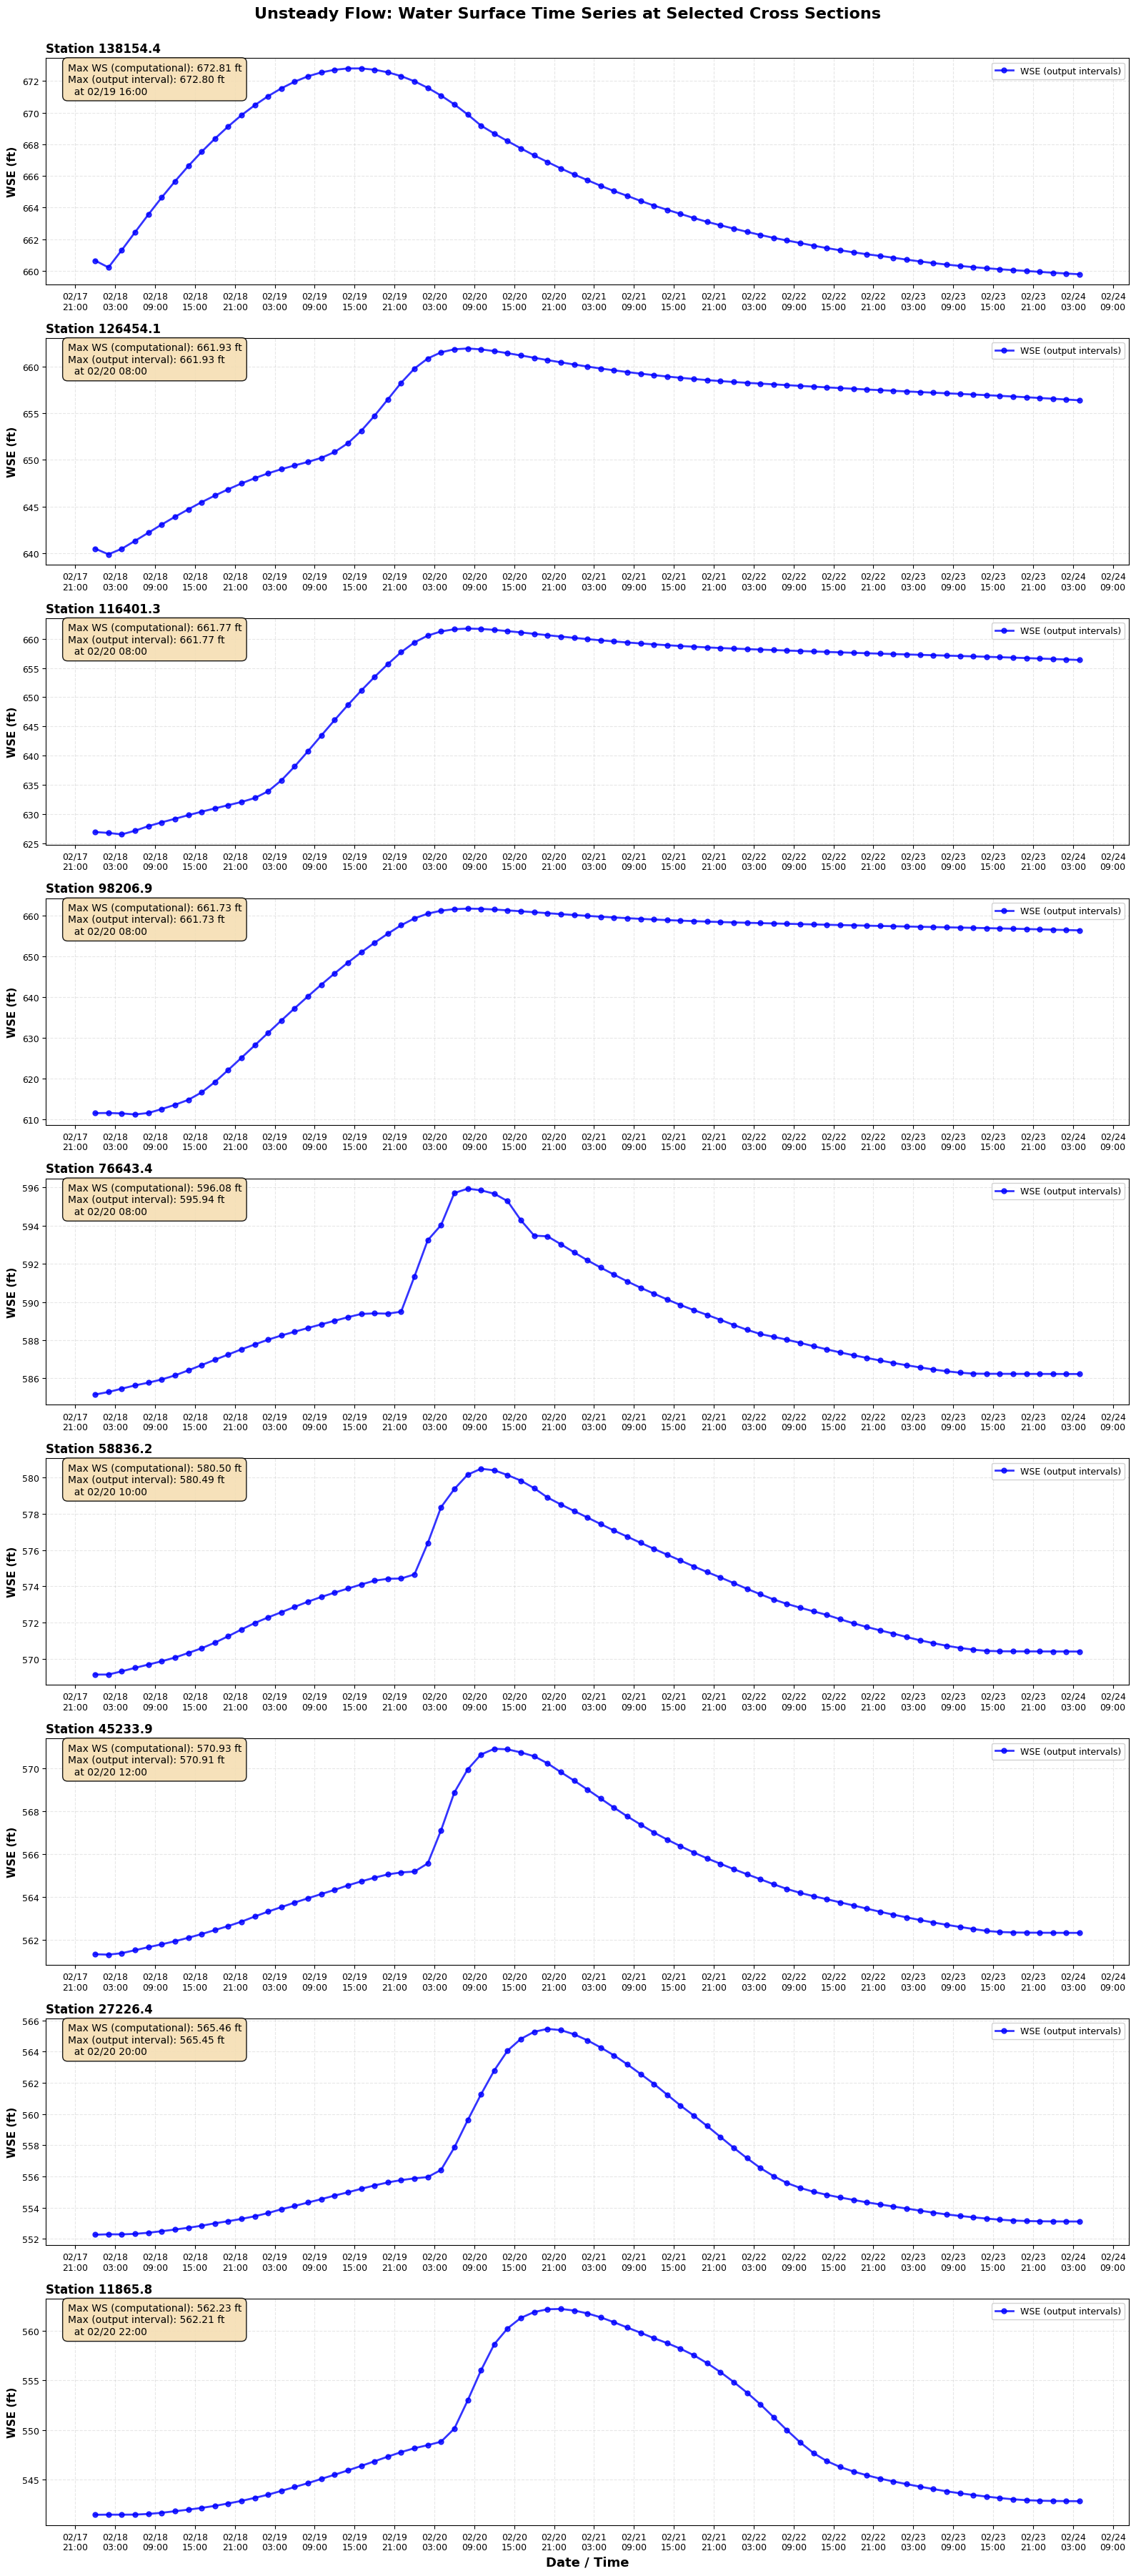


✓ Created time series plots for 9 stations


In [20]:
# ============================================================================
# UNSTEADY FLOW: Time Series at Multiple Cross Sections
# ============================================================================
# NOTE: This cell shows LEGACY manual datetime parsing for reference.
# For v0.81.0+, see the cell below for automatic datetime usage!
# ============================================================================

import matplotlib.dates as mdates
import numpy as np

# Convert node_id to float
df_unsteady['node_id'] = df_unsteady['node_id'].astype(float)

# Separate Max WS from timeseries data
df_maxws = df_unsteady[df_unsteady['time_string'] == 'Max WS'].copy()
df_timeseries = df_unsteady[df_unsteady['time_string'] != 'Max WS'].copy()

# LEGACY: Parse datetime for timeseries (NOT NEEDED in v0.81.0+ - datetime column auto-included!)
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['time_string'], 
                                           format='%d%b%Y %H%M', errors='coerce')

# Select cross sections to plot (every 20th station for manageable plot count)
all_xs = sorted(df_timeseries['node_id'].unique(), reverse=True)  # Upstream to downstream
selected_xs = all_xs[::20]  # Adjust step size as needed (20, 30, etc.)

if len(selected_xs) == 0:
    selected_xs = [all_xs[0]]  # At least plot one

print(f"Creating time series plots for {len(selected_xs)} cross sections:")
print(f"  Stations: {[f'{xs:.1f}' for xs in selected_xs]}\n")

# Create subplots - one per cross section
n_xs = len(selected_xs)
fig, axes = plt.subplots(n_xs, 1, figsize=(16, 4*n_xs))
if n_xs == 1:
    axes = [axes]

for idx, xs in enumerate(selected_xs):
    ax = axes[idx]
    
    # Get data for this cross section
    xs_data = df_timeseries[df_timeseries['node_id'] == xs].sort_values('datetime')
    maxws_data = df_maxws[df_maxws['node_id'] == xs]
    
    if len(xs_data) == 0:
        ax.text(0.5, 0.5, f'No data for station {xs:.1f}', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Plot WSE time series
    ax.plot(xs_data['datetime'], xs_data['wsel'], 
            'b-o', linewidth=2, markersize=5, label='WSE (output intervals)', 
            alpha=0.8)
    
    # Get max values
    max_ws_value = maxws_data['wsel'].iloc[0] if len(maxws_data) > 0 else None
    max_output_value = xs_data['wsel'].max()
    max_output_time = xs_data.loc[xs_data['wsel'].idxmax(), 'datetime']
    
    # Add horizontal line for computational Max WS
    #if max_ws_value:
    #    ax.axhline(max_ws_value, color='r', linestyle='--', 
    #               linewidth=2, alpha=0.7, label='Max WS (computational)')
    
    # Create annotation text box
    annotation_lines = [
        f"Max WS (computational): {max_ws_value:.2f} ft" if max_ws_value else "Max WS: N/A",
        f"Max (output interval): {max_output_value:.2f} ft",
        f"  at {max_output_time.strftime('%m/%d %H:%M')}" if pd.notna(max_output_time) else ""
    ]
    annotation_text = '\n'.join(annotation_lines)
    
    ax.text(0.02, 0.98, annotation_text, 
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, pad=0.5))
    
    # Formatting
    ax.set_ylabel('WSE (ft)', fontsize=11, fontweight='bold')
    ax.set_title(f'Station {xs:.1f}', fontsize=12, fontweight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis for dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Adjust interval as needed
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=9)

# Add common x-label to bottom subplot
axes[-1].set_xlabel('Date / Time', fontsize=13, fontweight='bold')

plt.suptitle('Unsteady Flow: Water Surface Time Series at Selected Cross Sections',
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

print(f"\n✓ Created time series plots for {len(selected_xs)} stations")

## NEW in v0.81.0: Automatic Datetime Parsing

Starting in version 0.81.0, `get_unsteady_results()` automatically includes a `datetime` column with proper datetime64[ns] objects. **Manual parsing is no longer needed!**

**Key Improvements:**
- ✅ `datetime` column added automatically
- ✅ Already in datetime64[ns] format (not strings)
- ✅ "Max WS" rows have `pd.NaT` for clean filtering
- ✅ Immediate compatibility with pandas datetime operations
- ✅ Backward compatible - `time_string` still included

The cell above shows the old manual parsing method (kept for reference). The next cell demonstrates the modern approach using the automatic `datetime` column.

In [21]:
# ============================================================================
# MODERN APPROACH: Using Automatic datetime Column (v0.81.0+)
# ============================================================================

# Check that datetime column exists and is already parsed
print("DataFrame columns:")
print(df_unsteady.columns.tolist())
print(f"\ndatetime column type: {df_unsteady['datetime'].dtype}")
print(f"Sample datetime values:")
print(df_unsteady[['time_string', 'datetime']].head(10))

# Separate using datetime column (NaT for Max WS rows)
df_maxws_modern = df_unsteady[df_unsteady['datetime'].isna()].copy()
df_timeseries_modern = df_unsteady[df_unsteady['datetime'].notna()].copy()

print(f"\nMax WS rows: {len(df_maxws_modern)}")
print(f"Timeseries rows: {len(df_timeseries_modern)}")

# Use pandas datetime accessors directly - no manual parsing needed!
print("\nDatetime operations (no parsing required!):")
print(f"  Simulation start: {df_timeseries_modern['datetime'].min()}")
print(f"  Simulation end: {df_timeseries_modern['datetime'].max()}")
print(f"  Duration: {df_timeseries_modern['datetime'].max() - df_timeseries_modern['datetime'].min()}")
print(f"  Unique hours: {df_timeseries_modern['datetime'].dt.hour.unique()[:10]}")

# Time-based filtering (modern approach)
# Example: Get data for a specific date
specific_date = pd.Timestamp('1999-02-19')
feb_19_data = df_timeseries_modern[df_timeseries_modern['datetime'].dt.date == specific_date.date()]
print(f"\nData points on {specific_date.date()}: {len(feb_19_data)}")

# Example: Get data for specific time range
start_time = pd.Timestamp('1999-02-18 12:00:00')
end_time = pd.Timestamp('1999-02-20 12:00:00')
time_range_data = df_timeseries_modern[
    (df_timeseries_modern['datetime'] >= start_time) & 
    (df_timeseries_modern['datetime'] <= end_time)
]
print(f"Data points between {start_time} and {end_time}: {len(time_range_data)}")

print("\n✓ Modern datetime functionality demonstrated")

DataFrame columns:
['river', 'reach', 'node_id', 'time_index', 'time_string', 'datetime', 'wsel', 'min_ch_el', 'velocity', 'flow', 'froude', 'energy', 'max_depth']

datetime column type: datetime64[ns]
Sample datetime values:
      time_string            datetime
0          Max WS                 NaT
1  18FEB1999 0000 1999-02-18 00:00:00
2  18FEB1999 0200 1999-02-18 02:00:00
3  18FEB1999 0400 1999-02-18 04:00:00
4  18FEB1999 0600 1999-02-18 06:00:00
5  18FEB1999 0800 1999-02-18 08:00:00
6  18FEB1999 1000 1999-02-18 10:00:00
7  18FEB1999 1200 1999-02-18 12:00:00
8  18FEB1999 1400 1999-02-18 14:00:00
9  18FEB1999 1600 1999-02-18 16:00:00

Max WS rows: 178
Timeseries rows: 13350

Datetime operations (no parsing required!):
  Simulation start: 1999-02-18 00:00:00
  Simulation end: 1999-02-24 04:00:00
  Duration: 6 days 04:00:00
  Unique hours: [ 0  2  4  6  8 10 12 14 16 18]

Data points on 1999-02-19: 2136
Data points between 1999-02-18 12:00:00 and 1999-02-20 12:00:00: 4450

✓ Modern dat

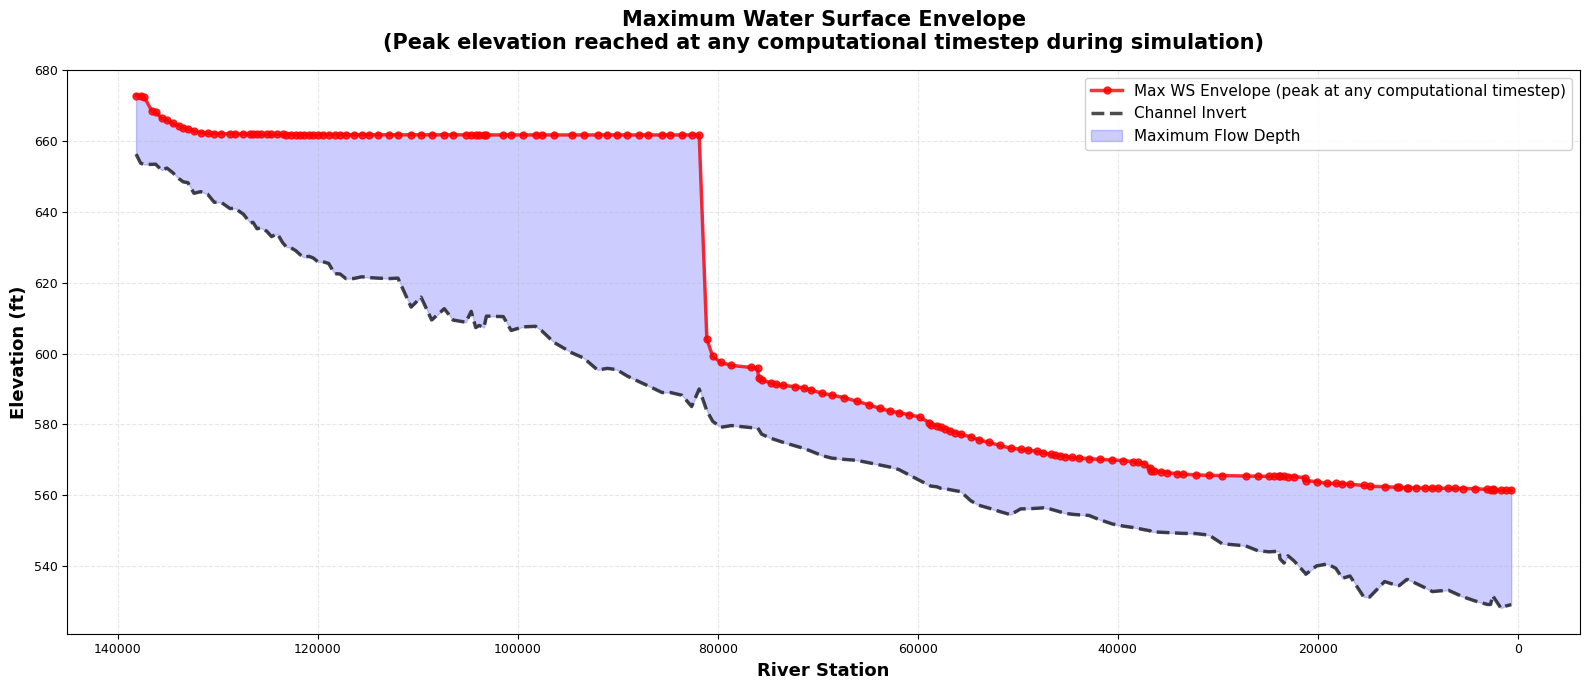


✓ Maximum Water Surface Envelope
  Max depth: 76.66 ft at station 82607.9
  Highest WSE: 672.81 ft at station 138154.4


In [22]:
# ============================================================================
# UNSTEADY FLOW: Maximum Water Surface Envelope
# ============================================================================

# Sort by station for profile view
max_wse_sorted = df_maxws.sort_values('node_id', ascending=False)

fig, ax = plt.subplots(figsize=(16, 7))

# Plot maximum WSE envelope
ax.plot(max_wse_sorted['node_id'], max_wse_sorted['wsel'],
        'r-o', linewidth=2.5, markersize=5, 
        label='Max WS Envelope (peak at any computational timestep)', 
        alpha=0.8)

# Add channel invert
invert = max_wse_sorted[['node_id', 'min_ch_el']].drop_duplicates('node_id').sort_values('node_id', ascending=False)
ax.plot(invert['node_id'], invert['min_ch_el'],
        'k--', linewidth=2.5, alpha=0.7, label='Channel Invert')

# Fill between for visual clarity
ax.fill_between(max_wse_sorted['node_id'], 
                max_wse_sorted['min_ch_el'], 
                max_wse_sorted['wsel'],
                alpha=0.2, color='blue', label='Maximum Flow Depth')

# Formatting
ax.set_xlabel('River Station', fontsize=13, fontweight='bold')
ax.set_ylabel('Elevation (ft)', fontsize=13, fontweight='bold')
ax.set_title('Maximum Water Surface Envelope\n(Peak elevation reached at any computational timestep during simulation)',
             fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.invert_xaxis()  # Upstream on left

plt.tight_layout()
plt.show()

# Print summary statistics
max_depth = (max_wse_sorted['wsel'] - max_wse_sorted['min_ch_el']).max()
max_depth_station = max_wse_sorted.loc[(max_wse_sorted['wsel'] - max_wse_sorted['min_ch_el']).idxmax(), 'node_id']

print(f"\n✓ Maximum Water Surface Envelope")
print(f"  Max depth: {max_depth:.2f} ft at station {max_depth_station:.1f}")
print(f"  Highest WSE: {max_wse_sorted['wsel'].max():.2f} ft at station {max_wse_sorted.loc[max_wse_sorted['wsel'].idxmax(), 'node_id']:.1f}")


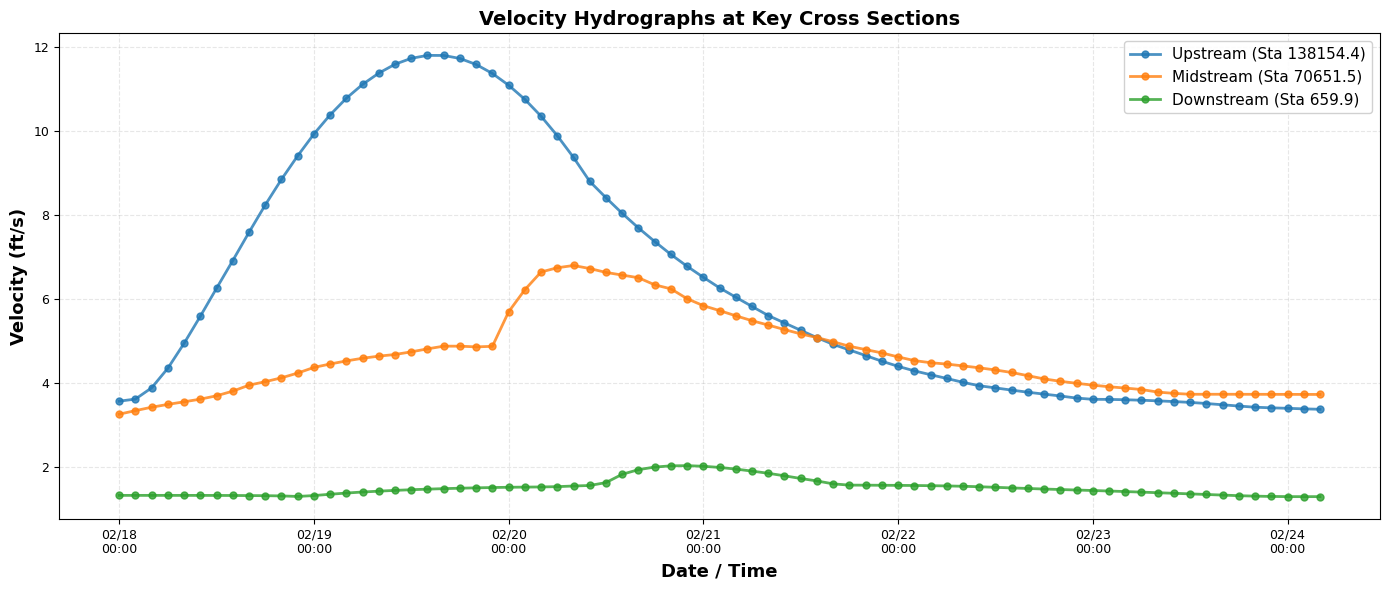


✓ Created velocity hydrographs for 3 key locations


In [23]:
# ============================================================================
# UNSTEADY FLOW: Velocity Hydrographs at Key Locations
# ============================================================================

# Select critical stations (upstream, middle, downstream)
all_stations = sorted(df_timeseries['node_id'].unique(), reverse=True)
n_stations = len(all_stations)

if n_stations >= 3:
    critical_xs = [
        all_stations[0],                    # Upstream
        all_stations[n_stations // 2],      # Middle
        all_stations[-1]                    # Downstream
    ]
    labels = ['Upstream', 'Midstream', 'Downstream']
else:
    critical_xs = all_stations
    labels = [f'Station {i+1}' for i in range(len(critical_xs))]

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot velocity hydrographs
for idx, (xs, label) in enumerate(zip(critical_xs, labels)):
    xs_data = df_timeseries[df_timeseries['node_id'] == xs].sort_values('datetime')
    ax.plot(xs_data['datetime'], xs_data['velocity'],
            marker='o', linewidth=2, markersize=5,
            color=colors[idx % len(colors)],
            label=f'{label} (Sta {xs:.1f})', alpha=0.8)

ax.set_xlabel('Date / Time', fontsize=13, fontweight='bold')
ax.set_ylabel('Velocity (ft/s)', fontsize=13, fontweight='bold')
ax.set_title('Velocity Hydrographs at Key Cross Sections', 
              fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))

plt.tight_layout()
plt.show()

print(f"\n✓ Created velocity hydrographs for {len(critical_xs)} key locations")

# Summary

## Complete RasControl API

```python
# Initialize with version (flexible formats)
init_ras_project(path, "4.1")  # or "41", "66", "5.0.6", "506", etc.

# Run plans (auto-sets as current, waits for completion)
# NOTE: run_plan() now checks if plan is current before running
# If results are up-to-date, it skips computation (faster workflow)
success, msgs = RasControl.run_plan("02")

# To force recomputation regardless of current status:
success, msgs = RasControl.run_plan("02", force_recompute=True)

# Extract steady (auto-sets as current)
df_steady = RasControl.get_steady_results("02")

# Extract unsteady (auto-sets as current, includes Max WS)
df_unsteady = RasControl.get_unsteady_results("01")

# Filter for time series plotting
df_timeseries = df_unsteady[df_unsteady['time_string'] != 'Max WS']
max_wse = df_unsteady[df_unsteady['time_string'] == 'Max WS']['wsel'].iloc[0]
```

## Key Features

- ✅ Plan numbers (not file paths)
- ✅ Auto-sets current plan
- ✅ Blocks until completion
- ✅ Steady AND unsteady
- ✅ All versions 3.0-6.7
- ✅ Flexible version formats
- ✅ Includes Max WS data
- ✅ Multi-version comparison (optional)

## What Was Demonstrated

1. **Steady workflow** - Plan 02 extraction and plotting
2. **Unsteady workflow** - Plan 01 time series with Max WS reference
3. **Max WS handling** - Understanding and visualizing peak values
4. **Multi-version comparison** - Optional cells for version validation

## Next Steps

- Apply to your legacy HEC-RAS models
- Run multi-version comparison for migration validation
- For HEC-RAS 6.0+: Use HDF methods for better performance
  - `19_steady_flow_analysis.ipynb`
  - `10_1d_hdf_data_extraction.ipynb`

### What This Creates

Running the multi-version comparison cells will:

**New Plans in Project:**
- `02_41`, `02_506`, `02_63`, `02_66` (steady)
- `01_41`, `01_506`, `01_63`, `01_66` (unsteady)

**CSV Files in working/:**
- `steady_v41.csv`, `steady_v506.csv`, `steady_v63.csv`, `steady_v66.csv`
- `unsteady_v41.csv`, `unsteady_v506.csv`, `unsteady_v63.csv`, `unsteady_v66.csv`

**Results:**
- All plans remain in project for further analysis
- CSV files for external comparison
- Plots showing version differences

In [ ]:
# =============================================================================
# OPTIONAL: Multi-version unsteady comparison (SKIP for automated testing)
# =============================================================================
# This cell runs multiple HEC-RAS versions and takes 1-2 hours.
# Set SKIP_MULTIVERSION = False to run the comparison.
# =============================================================================

SKIP_MULTIVERSION = True  # Set to False to run optional multi-version comparisons

if SKIP_MULTIVERSION:
    print("Skipping multi-version unsteady comparison (SKIP_MULTIVERSION=True)")
    print("Set SKIP_MULTIVERSION = False in the cell above to run this analysis")
    unsteady_results = {}
    max_ws_data = {}
else:
    from ras_commander import RasPlan

    # Step 1: Update Plan 01 output intervals for more detail
    print("Step 1: Updating Plan 01 intervals...")
    init_ras_project(project_path, RAS_VERSION)  # Use latest for modification

    # Update intervals: Output=15MIN, Mapping=15MIN
    RasPlan.update_plan_intervals("01", 
                                  output_interval="10MIN",
                                  mapping_interval="10MIN")
    print("  Output Interval: 1HOUR -> 6MIN")
    print("  Mapping Interval: 1HOUR -> 6MIN\n")

    # Step 2: Run across versions
    # All versions with actual COM interfaces
    test_versions = [
        ("4.1", "41"),       # HEC-RAS 4.1     -> RAS41.HECRASController
    #    ("5.0.1", "501"),    # HEC-RAS 5.0.1   -> RAS501.HECRASController  >> FREEZES, SKIP, LIKELY ISSUE WITH HECRASCONTROLLER
    #    ("5.0.3", "503"),    # HEC-RAS 5.0.3   -> RAS503.HECRASController
        ("5.0.4", "504"),    # HEC-RAS 5.0.4   -> RAS504.HECRASController
        ("5.0.6", "506"),    # HEC-RAS 5.0.6   -> RAS506.HECRASController
        ("6.3.1", "631"),    # HEC-RAS 6.3.1   -> RAS631.HECRASController
        ("6.6", "66"),       # HEC-RAS 6.6     -> RAS66.HECRASController
    ]

    unsteady_results = {}
    max_ws_data = {}  # Store Max WS separately

    print("=== MULTI-VERSION UNSTEADY COMPARISON ===\n")

    for version_name, version_code in test_versions:
        print(f"Processing HEC-RAS {version_name}...")
        
        # Clone Plan 01 for this version
        new_plan = RasPlan.clone_plan("01",
                          new_shortid=f"Unsteady_{version_code}",
                          new_title=f"Unsteady - v{version_name}")
        print(f"  Cloned to Plan {new_plan}")
        
        # Re-initialize with this version
        init_ras_project(project_path, version_name)
        
        # Run the plan (this will take several minutes!)
        print(f"  Running Plan {new_plan} (may take 5-10 min)...")
        # NOTE: Using force_recompute=True for fresh cloned plans to ensure computation
        # (Default behavior now checks if plan is current and skips if already computed)
        #success, msgs = RasControl.run_plan(new_plan, force_recompute=True)
        success, msgs = RasControl.run_plan(new_plan, force_recompute=True)
        print(success, msgs)
        if success:
            # Extract results (limit to 20 timesteps for comparison)
            df = RasControl.get_unsteady_results(new_plan)
            
            # Separate Max WS from timeseries
            max_ws_data[version_name] = df[df['time_string'] == 'Max WS'].copy()
            unsteady_results[version_name] = df[df['time_string'] != 'Max WS'].copy()
            
            # Save CSV
            csv_path = Path(f"working/unsteady_v{version_code}.csv")
            df.to_csv(csv_path, index=False)
            print(f"  Extracted {len(df)} rows -> {csv_path}")
        else:
            print(f"  Failed")
        
        print()

In [ ]:
# =============================================================================
# Plot multi-version unsteady comparison (if data available)
# =============================================================================

if unsteady_results:
    # Gather all station IDs across versions
    xs_set = set()
    for df in unsteady_results.values():
        try:
            xs_set.update(df['node_id'].astype(float).unique().tolist())
        except Exception:
            xs_set.update(df['node_id'].unique().tolist())

    all_xs = sorted(xs_set, reverse=True)  # upstream -> downstream
    if not all_xs:
        print("No cross section data found in unsteady_results")
    else:
        # Select every 5th cross section for plotting (adjust step as needed)
        step = 5
        selected_xs = all_xs[::step] if len(all_xs) > step else all_xs
        print(f"Plotting {len(selected_xs)} stations (every {step}th of {len(all_xs)} total)")

        for xs_id in selected_xs:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

            # Plot WSE time series for each version at this station
            for version, df in unsteady_results.items():
                # FIX: Convert node_id to float for comparison
                df_float = df.copy()
                df_float['node_id'] = df_float['node_id'].astype(float)
                xs_data = df_float[df_float['node_id'] == xs_id].sort_values('time_index')
                if len(xs_data):
                    ax1.plot(xs_data['time_index'], xs_data['wsel'],
                             marker='o', label=f'v{version}', alpha=0.8)

            # Add Max WS reference lines (if available) for this station
            for version, df in max_ws_data.items():
                try:
                    df_float = df.copy()
                    df_float['node_id'] = df_float['node_id'].astype(float)
                    max_row = df_float[df_float['node_id'] == xs_id]
                    if len(max_row):
                        max_wse = float(max_row['wsel'].iloc[0])
                        ax1.axhline(max_wse, linestyle='--', alpha=0.5, label=f'MaxWS v{version}')
                except Exception:
                    continue

            ax1.set_xlabel('Time Index', fontsize=11)
            ax1.set_ylabel('Water Surface Elevation (ft)', fontsize=11)
            ax1.set_title(f'WSE Time Series at {xs_id} - Version Comparison',
                          fontsize=13, fontweight='bold')
            ax1.legend(fontsize=8)
            ax1.grid(True, alpha=0.3)

            # Plot Flow time series for each version at this station
            for version, df in unsteady_results.items():
                # FIX: Convert node_id to float for comparison
                df_float = df.copy()
                df_float['node_id'] = df_float['node_id'].astype(float)
                xs_data = df_float[df_float['node_id'] == xs_id].sort_values('time_index')
                if len(xs_data):
                    ax2.plot(xs_data['time_index'], xs_data['flow'],
                             marker='o', label=f'v{version}', alpha=0.8)

            ax2.set_xlabel('Time Index', fontsize=11)
            ax2.set_ylabel('Flow (cfs)', fontsize=11)
            ax2.set_title(f'Flow Time Series at {xs_id} - Version Comparison',
                          fontsize=13, fontweight='bold')
            ax2.legend(fontsize=8)
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Basic per-station stats
            print(f"\nStation {xs_id}:")
            for version, df in unsteady_results.items():
                df_float = df.copy()
                df_float['node_id'] = df_float['node_id'].astype(float)
                xs_data = df_float[df_float['node_id'] == xs_id]
                if len(xs_data):
                    print(f"  v{version}: timesteps={len(xs_data)}, max_wse={xs_data['wsel'].max():.2f} ft")
                else:
                    print(f"  v{version}: no data")

        # Summary of Max WS across versions for the first selected station (if any)
        if selected_xs:
            summary_xs = selected_xs[0]
            print(f"\nMax WSE by version at station {summary_xs}:")
            for version, df in max_ws_data.items():
                try:
                    df_float = df.copy()
                    df_float['node_id'] = df_float['node_id'].astype(float)
                    max_row = df_float[df_float['node_id'] == summary_xs]
                    if len(max_row):
                        max_wse = float(max_row['wsel'].iloc[0])
                        print(f"  v{version}: {max_wse:.2f} ft")
                    else:
                        print(f"  v{version}: N/A")
                except Exception:
                    print(f"  v{version}: N/A")

else:
    print("Skipping multi-version unsteady comparison plots (no data)")
    print("Set SKIP_MULTIVERSION = False in cell above to run the analysis")

## Legacy HEC-RAS Automation Reference

### HEC Documentation

- **HEC-RAS 5.0 User's Manual**: Includes COM interface documentation
  https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx
- **Controller Interface Guide**: Documentation for HECRASController COM object

### COM Interface Limitations

**Performance**:
- Slower than direct file access
- Opens GUI (requires active desktop)
- Single-threaded (no parallel execution)

**Stability**:
- Depends on HEC-RAS installation
- Version-specific (COM interface changes between versions)
- Can leave HEC-RAS processes orphaned

**Functionality**:
- Limited to operations HEC-RAS exposes via COM
- Cannot access some file-level details
- No access to HDF structure (HEC-RAS 5.x)

### Modern Alternatives

| Task | Legacy (RasControl) | Modern (HEC-RAS 6.x+) |
|------|---------------------|----------------------|
| Execute plan | `RasControl.compute_plan()` | `RasCmdr.compute_plan()` |
| Extract WSE | `RasControl.get_steady_results()` | `HdfResultsPlan.get_wse()` |
| Extract velocity | `RasControl.get_unsteady_results()` | `HdfResultsPlan.get_velocity()` |
| Modify geometry | COM methods | `RasGeometry` file parsing |
| Modify plans | COM methods | `RasPlan` file editing |

### Version Comparison Workflow

This notebook demonstrates running **same project in multiple HEC-RAS versions** for validation:

```python
# Run in HEC-RAS 5.0.7
ras507_results = run_with_version("5.0.7", project_path, "01")

# Run in HEC-RAS 6.3
ras63_results = run_with_version("6.3", project_path, "01")

# Compare results
comparison = compare_wse_profiles(ras507_results, ras63_results)

# Document differences
comparison.to_csv('version_comparison.csv')
```

**Use cases**:
- **Model validation**: Confirm results consistent across versions
- **Migration testing**: Verify HEC-RAS upgrade doesn't change results
- **Regression testing**: Detect unexpected changes from HEC-RAS updates

### LLM Forward: Multi-Version Documentation

Document version comparison for peer review:

```python
def document_version_comparison(versions_tested, results_dict, output_file):
    import pandas as pd
    import json

    comparison_report = {
        'versions_tested': versions_tested,
        'comparison_date': datetime.now().isoformat(),
        'summary_statistics': {}
    }

    for version, results_df in results_dict.items():
        comparison_report['summary_statistics'][version] = {
            'num_nodes': len(results_df),
            'mean_wse': float(results_df['wse'].mean()),
            'max_wse': float(results_df['wse'].max()),
            'min_wse': float(results_df['wse'].min())
        }

    # Export comparison
    with open(output_file, 'w') as f:
        json.dump(comparison_report, f, indent=2)

    # Also export detailed CSV
    csv_file = output_file.with_suffix('.csv')
    combined_df = pd.concat([
        results_df.assign(version=version)
        for version, results_df in results_dict.items()
    ])
    combined_df.to_csv(csv_file, index=False)

    print(f"Version comparison documented: {output_file}")

# Usage - save to project folder
document_version_comparison(
    versions_tested=["5.0.7", "6.3"],
    results_dict={'5.0.7': ras507_df, '6.3': ras63_df},
    output_file=project_path / 'version_comparison.json'
)
```

This enables:
- **Validation documentation**: Proof that upgrade doesn't change results
- **Peer review**: Non-programmers can review statistics
- **Audit trail**: Record which versions were compared when

In [ ]:
# =============================================================================
# OPTIONAL: Multi-version steady state comparison (SKIP for automated testing)
# =============================================================================
# This cell runs multiple HEC-RAS versions and can take 30+ minutes.
# Set SKIP_MULTIVERSION = False in cell 29 to run this comparison.
# =============================================================================

if SKIP_MULTIVERSION:
    print("Skipping multi-version steady comparison (SKIP_MULTIVERSION=True)")
    print("Set SKIP_MULTIVERSION = False in cell above to run this analysis")
    steady_results = {}
else:
    from ras_commander import RasPlan

    # Versions to test - all versions with actual COM interfaces
    test_versions = [
      #  ("4.1", "41"),       # HEC-RAS 4.1     -> RAS41.HECRASController
      #  ("5.0.1", "501"),    # HEC-RAS 5.0.1   -> RAS501.HECRASController
      #  ("5.0.3", "503"),    # HEC-RAS 5.0.3   -> RAS503.HECRASController
        ("5.0.4", "504"),    # HEC-RAS 5.0.4   -> RAS504.HECRASController
        ("5.0.6", "506"),    # HEC-RAS 5.0.6   -> RAS506.HECRASController
        ("6.3.1", "631"),    # HEC-RAS 6.3.1   -> RAS631.HECRASController
        ("6.6", "66"),       # HEC-RAS 6.6     -> RAS66.HECRASController
    ]

    steady_results = {}

    print("=== MULTI-VERSION STEADY STATE COMPARISON ===\n")

    for version_name, version_code in test_versions:
        print(f"Processing HEC-RAS {version_name}...")
        
        # Clone Plan 02 for this version
        new_plan = RasPlan.clone_plan("02",
                          new_shortid=f"Steady_{version_code}",
                          new_title=f"Steady - v{version_name}")
        print(f"  Cloned to Plan {new_plan}")
        
        # Re-initialize with this version
        init_ras_project(project_path, version_name)
        
        # Run the plan using ras-commander's compute_plan() instead of RasControl.run_plan
        print(f"  Running Plan {new_plan} with 2 cores...")
        try:
            # Use direct command line execution, preferred over RasControl.run_plan
            #RasCmdr.compute_plan(new_plan, clear_geompre=True, num_cores=2)
            success, msgs = RasControl.run_plan(new_plan, force_recompute=True)
            print(success, msgs)
            # Extract results
            df = RasControl.get_steady_results(new_plan)
            steady_results[version_name] = df

            # Save CSV
            csv_path = Path(f"working/steady_v{version_code}.csv")
            df.to_csv(csv_path, index=False)
            print(f"  Extracted {len(df)} rows -> {csv_path}")
        except Exception as e:
            print(f"  Failed: {e}")

        print()

    # Plot comparison - first profile from each version
    if steady_results:
        fig, ax = plt.subplots(figsize=(14, 7))
        
        for version, df in steady_results.items():
            first_prof = df[df['profile'] == df['profile'].iloc[0]]
            ax.plot(range(len(first_prof)), first_prof['wsel'], 
                    marker='o', label=f'v{version}', alpha=0.7)
        
        ax.set_xlabel('Cross Section Index', fontsize=12)
        ax.set_ylabel('Water Surface Elevation (ft)', fontsize=12)
        ax.set_title('Steady State Profile - Multi-Version Comparison', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\nCompared {len(steady_results)} versions")

    else:
        print("No steady results to plot")